### Fachhochschule Kiel: Informatik und Elektrotechnik 
##### WS16/17

# Master Project
## Investigations on the use of deep learning for classifying epiphyses in hand radiographs

#### Authors: 
- Leopoldo Duenas Castro (leopoldo.castro@student.fh-kiel.de)
- Prateek Jitendra Bhatt (prateek.j.bhatt@student.fh-kiel.de)
- Soo Yam Tan (soo.y.tan@student.fh-kiel.de)

#### Supervising Professor:
- Prof. Dr. rer. nat. Carsten Meyer (carsten.meyer@fh-kiel.de)

### Abstract
Landmark detection is an important step in medical image analysis. The purpose of this work is
to use deep learning for classification of epiphyses in medical images of hands. Several
experiments were conducted to solve the problem on different stages (Binary, 8 classes and 37
classes classification).
The results obtained demonstrate the potential of multilayer perceptron, achieving 0.5%, 2.1%
and 3.4% evaluation error for binary, 8 classes and 37 classes classification, respectively.
Convolutional networks also seem promising with a 3.4% evaluation error obtained for the 37
classes task.
This work shows the impact of appropriate hyperparameters selection, such as learning rate and
number of epochs in the results.

Note: this Jupyter notebook is used to define the workflow and to perform the experiments. Details of the experiment results are documented separately in the Master Project report.

##### Tested on Microsoft CNTK V2.0 Beta 7 (https://github.com/Microsoft/CNTK/)

##### Overview:
1. Configure Parameters
    1. Dataset Specifications
    2. Modify Destination Folders
    3. Modify Training and Evaluation Parameters
2. Import Libraries 
3. Visualize Sample from Dataset
4. Configure Reader
5. Configure Neural Network Models
6. Configure Trainer
7. Configure Evaluation
8. Train and Evaluate Fully Connected Model
9. Train and Evaluate Convolution Network Model

### Step 1: Configure Parameters

#### 1.A. Dataset Specifications  </span>

##### <span style="color:red">*</span> Medical
Taken from Digital Hand Atlas provided by the Image Processing and Informatics Laboratory (IPI Lab)

<http://www.ipilab.org/Research/BAA/BAAindex.php>

Specifications:
- 895 publicly available grayscale X-ray images of hands with average size of 1563x2169, acquired with different X-ray scanners, resulting in large intensity variations
- 37 characteristics, e.g. finger tips or bone joints i.e. epiphysis, were annotated manually by an expert

In [1]:
evalOnly=False # flag to skip training and to perform evaluation on saved model

dataSet         = 'Medical'

imgSize_y       = 100
imgSize_x       = 100
num_channels    = 1 # gray-scale
num_labels      = 37
numFeature      = imgSize_y * imgSize_x * num_channels
label_names     = ['37',
                   '01','02','03','04','05','06','07','08','09','10',
                   '11','12','13','14','15','16','17','18','19','20',
                   '21','22','23','24','25','26','27','28','29','30',
                   '31','32','33','34','35','36']

#### 1.B. Modify Destination Folders (Optional)

In [2]:
data_dir        = './data/' + dataSet + '/'
model_directory = data_dir + 'Model'
fold            = 'fold1'
train_file      = data_dir + 'train_map_' + str(num_labels) + '_' + str(imgSize_y) + 'x' + str(imgSize_x) + '_' + fold + '.txt'
test_file       = data_dir + 'test_map_' + str(num_labels) + '_' + str(imgSize_y) + 'x' + str(imgSize_x) + '_' + fold + '.txt'

#### 1.C. Modify Training and Evaluation Parameters (Optional)

In [3]:
# Training configuration
train_max_epochs       = 150
train_epoch_size       = 22089 # corresponds to training sample size
train_minibatch_size   = 32

# Evaluation configuration
eval_epoch_size        = 11026 # corresponds to evaluation sample size
eval_minibatch_size    = 16        

### Step 2: Import Libraries

Use <i>conda install</i> to install additional libraries that are not in the CNTK package:
- scikit-learn
- xlsxwriter

In [4]:
# Required libraries
from PIL import Image
import numpy as np
import pickle as cp
import os
import sys
import tarfile
import xml.etree.cElementTree as et
import xml.dom.minidom
import matplotlib.pyplot as plt
import re
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools

try: 
    from urllib.request import urlretrieve 
except ImportError: 
    from urllib import urlretrieve

# Required CNTK libraries
import cntk as C
# C.set_default_device(C.gpu(0)) # required to force GPU to be used
from cntk.blocks import Placeholder, default_options, Input
from cntk.layers import Convolution, MaxPooling, Dense, Dropout, BatchNormalization 
from cntk.models import Sequential, LayerStack
from cntk.io import ImageDeserializer, MinibatchSource, StreamDefs, StreamDef
from cntk.initializer import glorot_uniform
from cntk import Trainer
from cntk.ops.functions import load_model
from cntk.learner import learning_rate_schedule, UnitType, momentum_as_time_constant_schedule, momentum_sgd, sgd
from cntk.ops import input_variable, element_times, relu, cross_entropy_with_softmax, classification_error, combine, softmax
from cntk.utils import *

# Config matplotlib for inline plotting
%matplotlib inline

### Step 3: Visualize Sample from Dataset

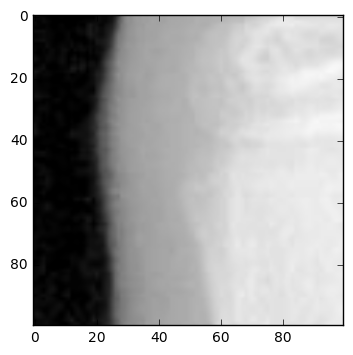

In [5]:
with open(train_file, 'r') as input_file:
    line = input_file.readline()
    train_data = re.split(r'\t|\n|', line)
    # Load test image
    im = Image.open(train_data[0])
    plt.imshow(im, cmap='gray', vmin=0, vmax=255)
    plt.show()
    plt.close()

### Step 4: Configure Reader

##### Possible optimizations
- Adding noise to the data can often improves generalization error. You can augment the training set by adding noise (generated with numpy, hint: use numpy.random) to the training images.
- Distort the images with affine transformation (translations or rotations)

In [6]:
# Define reader to feed data into network
def create_reader(map_file, mean_file, train):
    transforms = []
    if mean_file is not None:    # CNTK supports the use of a mean file to perform mean subtraction using the built-in reader
        transforms += [
            ImageDeserializer.scale(width=imgSize_x, height=imgSize_y, channels=num_channels, interpolations='linear'),
            ImageDeserializer.mean(mean_file)
        ]
    else:
        transforms += [
                ImageDeserializer.scale(width=imgSize_x, height=imgSize_y, channels=num_channels, interpolations='linear')
        ]
    # deserializer
    deserializer = ImageDeserializer(map_file, StreamDefs(
        features = StreamDef(field='image', transforms=transforms), # first column in map file is referred to as 'image'
        labels   = StreamDef(field='label', shape=num_labels)      # and second as 'label'
    ))
    
    if num_channels == 1: # modify deserializer to support gray scale images
        deserializer['grayscale'] = True 
    
    return MinibatchSource(deserializer)

### Step 5: Configure Neural Network Models

In [7]:
# Define network

def create_model_MLP(input, out_dims):
    with default_options(activation=relu):
            model = Sequential([
                Dense(900, init=glorot_uniform()),
                Dense(200, init=glorot_uniform()),
                Dense(150, init=glorot_uniform()),
                Dense(out_dims, init=glorot_uniform(), activation=None)
            ])

    return model(input)


def create_model_CONV(input, out_dims):
    with default_options(activation=relu):
        model = Sequential([            
            Convolution((5,5), 50, init=glorot_uniform()),
            MaxPooling((3,3), strides=(2,2)),
            Convolution((5,5), 50, init=glorot_uniform()),
            MaxPooling((3,3), strides=(2,2)),
            Convolution((5,5), 50, init=glorot_uniform()),
            MaxPooling((3,3), strides=(2,2)),
            Dense(out_dims, init=glorot_uniform(), activation=None)
        ])
    return model(input)

### Step 6: Configure Trainer

In [8]:
# Helper function to allow reuse of cross_entropy and classification_error functions
def create_criterion_function(model):
    labels = Placeholder()
    ce     = cross_entropy_with_softmax(model, labels)
    errs   = classification_error      (model, labels)
    return combine ([ce, errs])

# Define training
def train(reader_train, model_func):
    # Input variable denoting the features data
    input_var = input_variable((num_channels, imgSize_y, imgSize_x), name = 'input_var')
    
    # Normalize the input so that the pixel value will be scaled from 0-255 to 0-1
    feature_scale = 1.0 / 256.0
    input_var_norm = element_times(feature_scale, input_var)
    
    # create new model and apply it to input
    z = model_func(input_var_norm, out_dims=num_labels)

    # Define loss and metric
    criterion = create_criterion_function(z)
    criterion.replace_placeholders({criterion.placeholders[0]: Input(num_labels)})
    
    # Set training parameters
    lr_per_mb              = [0.05]*10 + [0.025]*10 + [0.01]
    lr_schedule            = learning_rate_schedule(lr_per_mb, epoch_size=train_epoch_size, unit=UnitType.minibatch)#sample)
    mm_time_constant       = -train_minibatch_size/np.log(0.90)
    mm_schedule            = momentum_as_time_constant_schedule(mm_time_constant)
    l2_reg_weight          = 0.001    
    
    # trainer object
    # with momentum
    learner     = momentum_sgd(criterion.parameters, 
                               lr_schedule, mm_schedule, 
                               l2_regularization_weight=l2_reg_weight)
    # without momentum
    #learner = sgd(criterion.parameters, lr_schedule)
    
    # instantiate trainer: model, cross entropy, classification error, learning params
    trainer     = Trainer(z, criterion.outputs[0], criterion.outputs[1], [learner])

    # define mapping from reader streams to network inputs
    input_map = {
        criterion.arguments[0]: reader_train.streams.features,
        criterion.arguments[1]: reader_train.streams.labels
    }

    log_number_of_parameters(z) ; 
    print()
    progress_printer = ProgressPrinter(tag='Training')

    # perform model training
    batch_index = 0
    plot_data = {'batchindex':[], 'loss':[], 'error':[]}
    
    for epoch in range(train_max_epochs):       # loop over epochs
        sample_count = 0
        while sample_count < train_epoch_size:  # loop over minibatches in the epoch
            data = reader_train.next_minibatch(
                min(train_minibatch_size, train_epoch_size - sample_count), input_map=input_map) # fetch minibatch.
            
            trainer.train_minibatch(data)                                            # update model with it

            sample_count += trainer.previous_minibatch_sample_count                  # count samples processed so far
            
            # For visualization...            
            plot_data['batchindex'].append(batch_index)
            plot_data['loss'].append(trainer.previous_minibatch_loss_average)
            plot_data['error'].append(trainer.previous_minibatch_evaluation_average)
            
            progress_printer.update_with_trainer(trainer, with_metric=True) # log progress
            batch_index += 1
        progress_printer.epoch_summary(with_metric=True)
        # Save model after every 5th epoch
        if epoch % 5 == 0:
            z.save_model(os.path.join(model_directory, dataSet + "_{}.dnn".format(epoch)))

    
    # save final trained model
    z.save_model(os.path.join(model_directory, dataSet + ".dnn"))
         
    # Visualize training result:
    window_width            = 32
    loss_cumsum             = np.cumsum(np.insert(plot_data['loss'], 0, 0)) 
    error_cumsum            = np.cumsum(np.insert(plot_data['error'], 0, 0)) 

    # Moving average.
    plot_data['batchindex'] = np.insert(plot_data['batchindex'], 0, 0)[window_width:]
    plot_data['avg_loss']   = (loss_cumsum[window_width:] - loss_cumsum[:-window_width]) / window_width
    plot_data['avg_error']  = (error_cumsum[window_width:] - error_cumsum[:-window_width]) / window_width
    
    plt.figure(1)
    plt.subplot(211)
    plt.plot(plot_data["batchindex"], plot_data["avg_loss"], 'b--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Loss')
    plt.title('Minibatch run vs. Training loss ')

    plt.show()

    plt.subplot(212)
    plt.plot(plot_data["batchindex"], plot_data["avg_error"], 'r--')
    plt.xlabel('Minibatch number')
    plt.ylabel('Label Prediction Error')
    plt.title('Minibatch run vs. Label Prediction Error ')
    plt.show()
    
    plt.close()
    
    return softmax(z)

### Step 7: Configure Evaluation

In [9]:
# Define evaluation
def evaluate(reader_test):
    model_filename = model_directory + '/' + dataSet + '.dnn'
    if not os.path.isfile(model_filename):
        print (model_filename, ' does not exist. Perform training step first.')
    else:       
        # load trained model
        z = load_model(model_filename)
        
        # Define loss and metric
        criterion = create_criterion_function(z)
        criterion.replace_placeholders({criterion.placeholders[0]: Input(num_labels)})
        
        # currently a dummy_learner is required to instantiate trainer
        # Set training parameters - will not be used 
        lr_per_minibatch       = learning_rate_schedule([0.01]*10 + [0.003]*10 + [0.001], UnitType.minibatch, eval_epoch_size)
        momentum_time_constant = momentum_as_time_constant_schedule(-eval_minibatch_size/np.log(0.9))
        l2_reg_weight          = 0.001

        dummy_learner     = momentum_sgd(criterion.parameters, 
                                   lr = lr_per_minibatch, momentum = momentum_time_constant, 
                                   l2_regularization_weight=l2_reg_weight)
        evaluator     = Trainer(z, criterion.outputs[0], criterion.outputs[1], [dummy_learner])
        
        # process minibatches and evaluate the model
        metric_numer    = 0
        metric_denom    = 0
        sample_count    = 0
        minibatch_index = 0

        progress_printer = ProgressPrinter(tag='Evaluation')
        while sample_count < eval_epoch_size:
            current_minibatch = min(eval_minibatch_size, eval_epoch_size - sample_count)

            # Fetch next test min batch.
            data = reader_test.next_minibatch(current_minibatch, input_map={  # fetch minibatch
                                                criterion.arguments[0]: reader_test.streams.features,
                                                criterion.arguments[1]: reader_test.streams.labels
            })

            # minibatch data to be trained with
            metric_numer += evaluator.test_minibatch(data) * current_minibatch
            metric_denom += current_minibatch

            # Keep track of the number of samples processed so far.
            sample_count += data[criterion.arguments[1]].num_samples
            minibatch_index += 1
            # log progress
            progress_printer.update(0, 
                                    data[criterion.arguments[1]].num_samples, 
                                    metric_numer/metric_denom)
            

        print("")
        print("Final Results: Minibatch[1-{}]: errs = {:0.1f}% * {}".format(minibatch_index+1, (metric_numer*100.0)/metric_denom, metric_denom))
        print("")
        
        return softmax(z)

### Step 8a: Train Fully Connected Model

Training 9216837 parameters in 8 parameter tensors.

Finished Epoch [1]: [Training] loss = 2.174625 * 22089, metric = 70.8% * 22089 224.023s ( 98.6 samples per second)
Finished Epoch [2]: [Training] loss = 1.452345 * 22089, metric = 53.5% * 22089 29.595s (746.4 samples per second)
Finished Epoch [3]: [Training] loss = 1.159126 * 22089, metric = 43.1% * 22089 29.489s (749.1 samples per second)
Finished Epoch [4]: [Training] loss = 1.083813 * 22089, metric = 40.3% * 22089 29.535s (747.9 samples per second)
Finished Epoch [5]: [Training] loss = 1.034279 * 22089, metric = 38.7% * 22089 29.332s (753.1 samples per second)
Finished Epoch [6]: [Training] loss = 0.950771 * 22089, metric = 35.1% * 22089 29.411s (751.1 samples per second)
Finished Epoch [7]: [Training] loss = 0.903333 * 22089, metric = 33.8% * 22089 29.745s (742.6 samples per second)
Finished Epoch [8]: [Training] loss = 0.854367 * 22089, metric = 31.4% * 22089 29.636s (745.4 samples per second)
Finished Epoch [9]: [Training] los

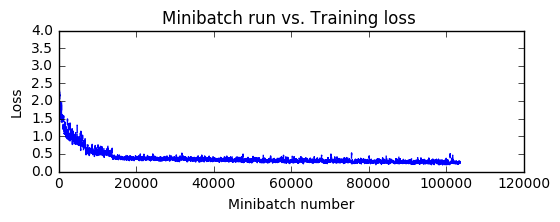

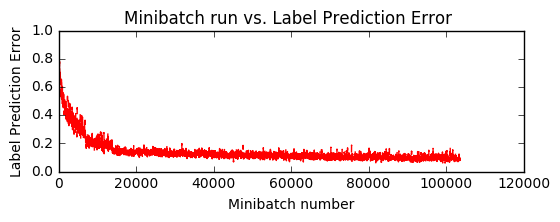

In [10]:
if not evalOnly:
    # Read Train Data
    reader_train = create_reader(train_file, None, True)
    # Start Training
    pred_train = train(reader_train, model_func=create_model_MLP)

### Step 8b: Evaluate Fully Connected Model

In [11]:
# Read Test Data
reader_test  = create_reader(test_file, None, False)
    
# Start Evaluation
pred_eval = evaluate(reader_test)


Final Results: Minibatch[1-691]: errs = 9.2% * 11026



### Step 8c: Test Fully Connected Model with Sample Image

In [12]:
def eval(image_num):
    
    for i in range(1, 38):
        image_path = data_dir + 'data/' + str(i) + '/' + str(image_num) + '.jpg_' + str(i) + '_' + str(imgSize_y) + str(imgSize_x) + '.png'
        # Prepare image
        im = Image.open(image_path)
        print('True label:', i)
        image_data   = np.array(im, dtype=np.float32)
        im.close()

        image_data = image_data.reshape(imgSize_y, imgSize_x, 1)

        image_data   = np.ascontiguousarray(np.transpose(image_data, (2, 0, 1)))

        # Load trained model
        model_filename = model_directory + '/' + dataSet + '.dnn'
        if not os.path.isfile(model_filename):
            print (model_filename, ' does not exist. Perform training step first.')
        else:       
            # load trained model
            z = load_model(model_filename)
            # Apply softmax to calculate regression/probabilities
            pred_op = softmax(z)

        result       = np.squeeze(pred_op.eval({pred_op.arguments[0]:[image_data]}))

        # Return top results:
        top_count = 3
        result_indices = (-np.array(result)).argsort()[:top_count]

        print("Ranked predictions:")
        for j in range(top_count):
            if int(label_names[result_indices[j]]) == i:
                print("\tLabel: {:10s}, confidence: {:.2f}% <--".format(label_names[result_indices[j]], result[result_indices[j]] * 100))
            else:
                print("\tLabel: {:10s}, confidence: {:.2f}%".format(label_names[result_indices[j]], result[result_indices[j]] * 100))

In [13]:
image_num = 4355

eval(image_num)

True label: 1
Ranked predictions:
	Label: 01        , confidence: 99.94% <--
	Label: 02        , confidence: 0.06%
	Label: 25        , confidence: 0.00%
True label: 2
Ranked predictions:
	Label: 02        , confidence: 99.93% <--
	Label: 01        , confidence: 0.07%
	Label: 37        , confidence: 0.00%
True label: 3
Ranked predictions:
	Label: 03        , confidence: 98.92% <--
	Label: 04        , confidence: 0.96%
	Label: 11        , confidence: 0.08%
True label: 4
Ranked predictions:
	Label: 04        , confidence: 99.84% <--
	Label: 03        , confidence: 0.16%
	Label: 10        , confidence: 0.00%
True label: 5
Ranked predictions:
	Label: 05        , confidence: 99.88% <--
	Label: 06        , confidence: 0.11%
	Label: 19        , confidence: 0.00%
True label: 6
Ranked predictions:
	Label: 06        , confidence: 99.44% <--
	Label: 13        , confidence: 0.31%
	Label: 09        , confidence: 0.23%
True label: 7
Ranked predictions:
	Label: 07        , confidence: 99.69% <--
	Labe

### Step 8d: Display Confusion Matrix for Fully Connected Model

In [14]:
def plot_confusion_matrix(cm):
    
    labels           = ['01','02','03','04','05','06','07','08','09','10',
                        '11','12','13','14','15','16','17','18','19','20',
                        '21','22','23','24','25','26','27','28','29','30',
                        '31','32','33','34','35','36','37']
    
    fig = plt.figure(figsize = (15,15))
    fig1 = fig.add_subplot(111)
    confmat = fig1.matshow(cm, cmap=plt.cm.Blues)
    fig1.set_title('Confusion Matrix')
    plt.colorbar(confmat, fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=90)
    plt.yticks(tick_marks, labels)
    
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.ylabel('Actual Labels')
    plt.xlabel('Predicted Labels')
    
def display_confusion_matrix(input_file):
    # initiate list to hold predicted and actual values
    label_pred = []
    label_actu = []

    # Load trained model
    model_filename = model_directory + '/' + dataSet + '.dnn'
    if not os.path.isfile(model_filename):
        print (model_filename, ' does not exist. Perform training step first.')
    else:       
        # load trained model
        pred_op = softmax(load_model(model_filename))

        with open(input_file, 'r') as read_file:
            for line in read_file:
                test_data = re.split(r'\t|\n|', line)

                # Load test image
                im = Image.open(test_data[0])
                image_data = np.array(im, dtype=np.float32)
                im.close()
                image_data = image_data.reshape(imgSize_y, imgSize_x, 1)
                image_data = np.ascontiguousarray(np.transpose(image_data, (2, 0, 1)))
                
                # perform evaluation
                result = np.squeeze(pred_op.eval({pred_op.arguments[0]:[image_data]}))

                top_count = num_labels
                result_indices = (-np.array(result)).argsort()[:top_count]

                # retrieve actual and predicted labels
                label_actu.append(label_names[int(test_data[1])])
                label_pred.append(label_names[result_indices[0]])

        # Prepare confusion matrix
        
        # 1. using pandas to save to Excel
        conf_actu = pd.Series(label_actu, name='Actual')
        conf_pred = pd.Series(label_pred, name='Predicted')
        df_confusion = pd.crosstab(conf_actu, conf_pred)
        writer = pd.ExcelWriter(os.path.join(data_dir, 'confusion_matrix.xlsx'), engine='xlsxwriter')
        df_confusion.to_excel(writer,'Confusion_Matrix')
        writer.save()
        
        # 2. using scikit to plot
        cm = confusion_matrix(label_actu, label_pred)
        plot_confusion_matrix(cm)

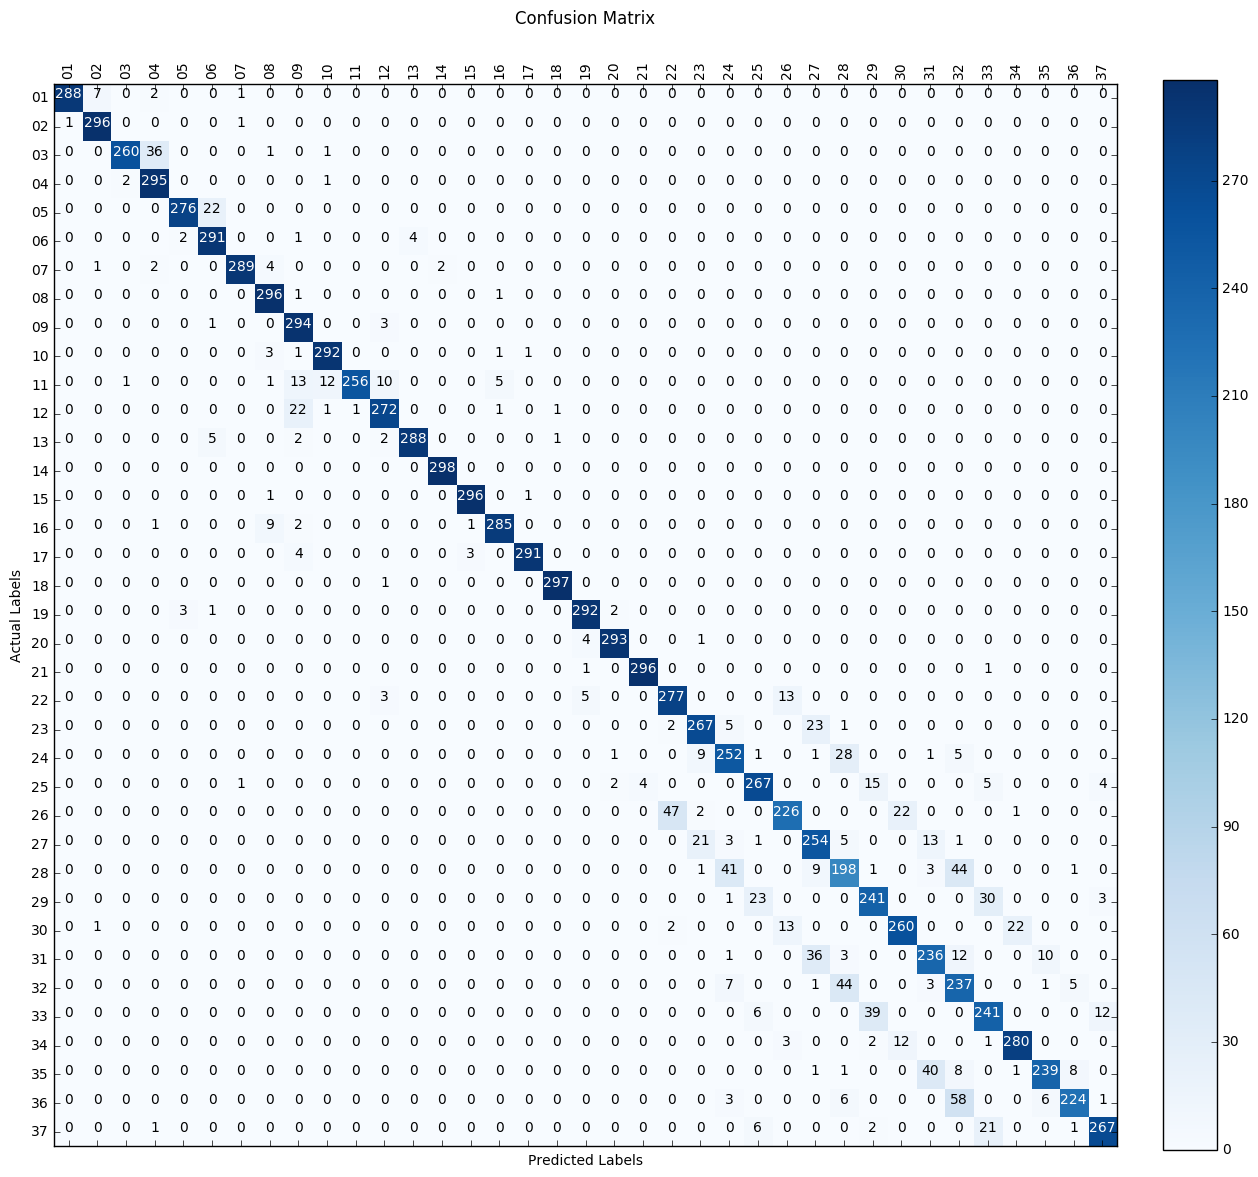

In [15]:
display_confusion_matrix(test_file)

### Step 9a: Train Convolution Network Model

Training 244837 parameters in 8 parameter tensors.

Finished Epoch [1]: [Training] loss = 2.629738 * 22089, metric = 74.3% * 22089 168.685s (130.9 samples per second)
Finished Epoch [2]: [Training] loss = 0.856621 * 22089, metric = 25.4% * 22089 111.334s (198.4 samples per second)
Finished Epoch [3]: [Training] loss = 0.527871 * 22089, metric = 16.6% * 22089 111.314s (198.4 samples per second)
Finished Epoch [4]: [Training] loss = 0.329358 * 22089, metric = 10.7% * 22089 111.022s (199.0 samples per second)
Finished Epoch [5]: [Training] loss = 0.277668 * 22089, metric = 9.1% * 22089 111.050s (198.9 samples per second)
Finished Epoch [6]: [Training] loss = 0.245768 * 22089, metric = 8.1% * 22089 111.052s (198.9 samples per second)
Finished Epoch [7]: [Training] loss = 0.225168 * 22089, metric = 7.5% * 22089 111.049s (198.9 samples per second)
Finished Epoch [8]: [Training] loss = 0.205182 * 22089, metric = 7.0% * 22089 111.044s (198.9 samples per second)
Finished Epoch [9]: [Training] l

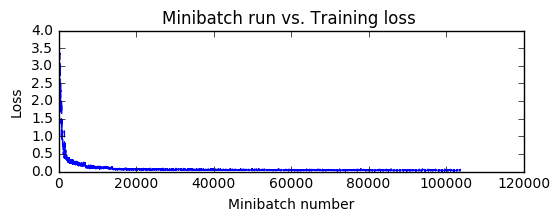

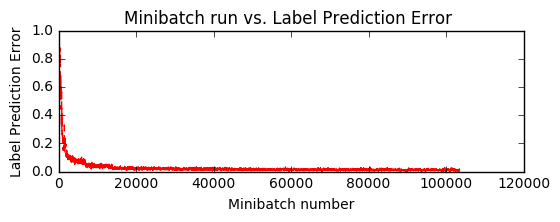

In [16]:
if not evalOnly:
    # Read Train Data
    reader_train = create_reader(train_file, None, True)
    # Start Training
    pred_train = train(reader_train, model_func=create_model_CONV)

### Step 9b: Evaluate Convolution Network Model

In [17]:
# Read Test Data
reader_test  = create_reader(test_file, None, False)
    
# Start Evaluation
pred_eval = evaluate(reader_test)


Final Results: Minibatch[1-691]: errs = 3.8% * 11026



### Step 9c: Test Convolution Model with Sample Image

In [19]:
image_num = 4355

eval(image_num)

True label: 1
Ranked predictions:
	Label: 01        , confidence: 100.00% <--
	Label: 04        , confidence: 0.00%
	Label: 02        , confidence: 0.00%
True label: 2
Ranked predictions:
	Label: 02        , confidence: 100.00% <--
	Label: 01        , confidence: 0.00%
	Label: 15        , confidence: 0.00%
True label: 3
Ranked predictions:
	Label: 03        , confidence: 100.00% <--
	Label: 04        , confidence: 0.00%
	Label: 11        , confidence: 0.00%
True label: 4
Ranked predictions:
	Label: 04        , confidence: 100.00% <--
	Label: 01        , confidence: 0.00%
	Label: 18        , confidence: 0.00%
True label: 5
Ranked predictions:
	Label: 05        , confidence: 100.00% <--
	Label: 06        , confidence: 0.00%
	Label: 35        , confidence: 0.00%
True label: 6
Ranked predictions:
	Label: 06        , confidence: 100.00% <--
	Label: 09        , confidence: 0.00%
	Label: 17        , confidence: 0.00%
True label: 7
Ranked predictions:
	Label: 07        , confidence: 100.00% <-

### Step 9d: Display Confusion Matrix for Convolution Network Model

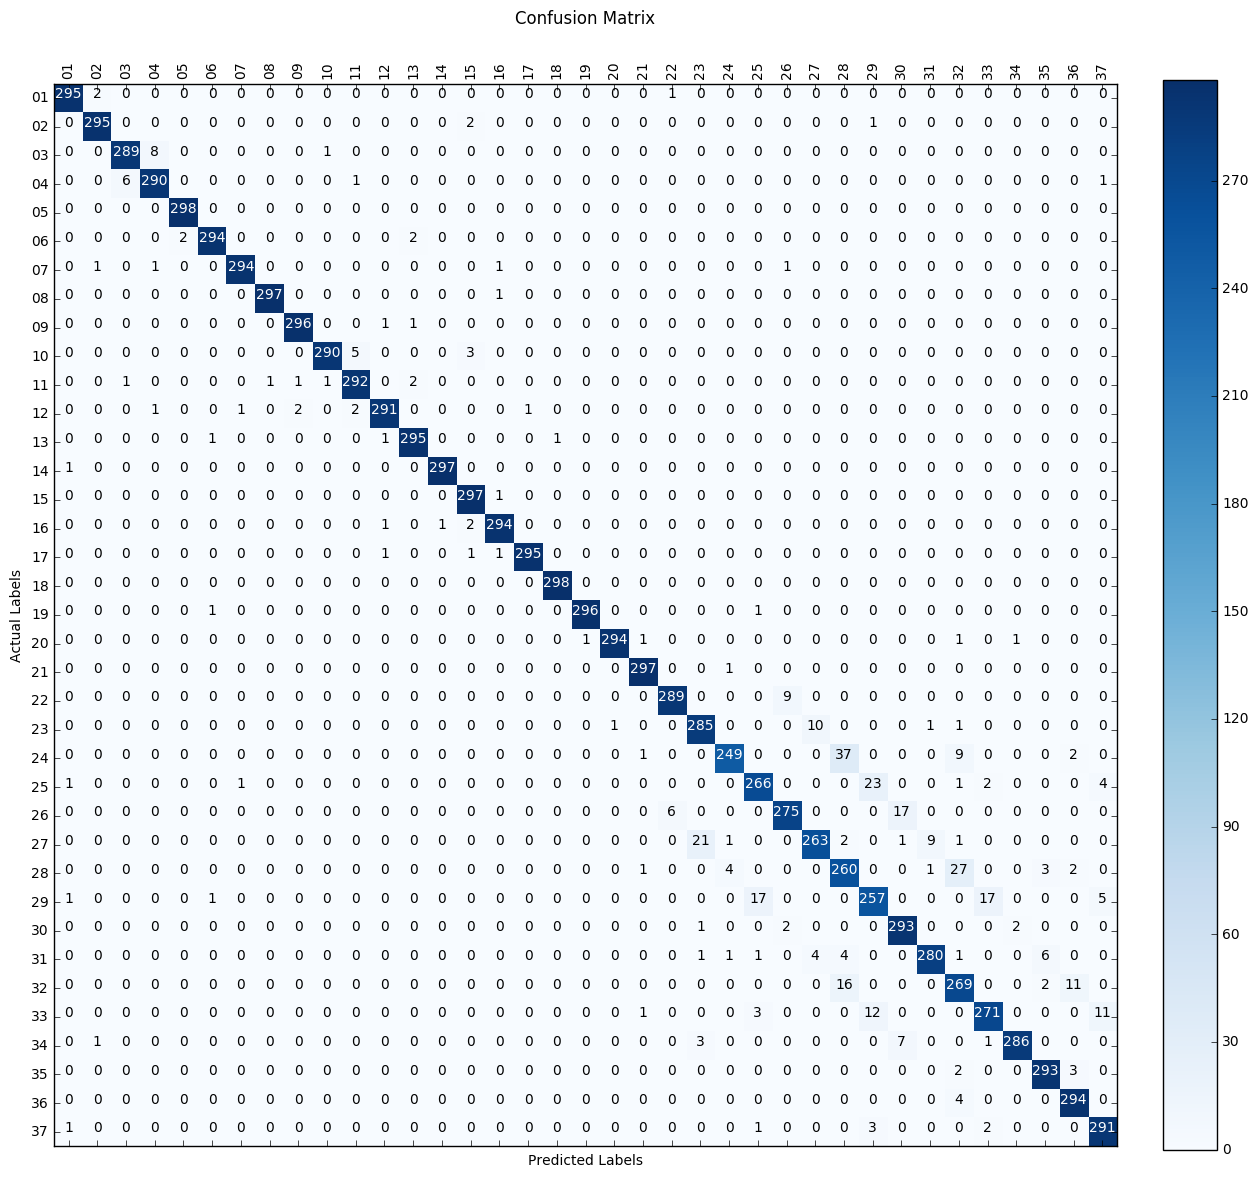

In [21]:
display_confusion_matrix(test_file)